# Clustering-Based Anomaly Detection with K-Means 


### Importing the Libraries

In [10]:

# Suppress all warning messages for cleaner output
import warnings
warnings.filterwarnings("ignore")

# Core libraries for file handling, data manipulation, and numerical operations
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Scikit-learn tools for clustering, metrics, preprocessing, and dimensionality reduction
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from scipy.spatial.distance import cdist
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Configure parallel processing limits to avoid excessive CPU usage on Windows systems
os.environ["LOKY_MAX_CPU_COUNT"] = "4"
os.environ["OMP_NUM_THREADS"] = "4"


### STEP 1: Load and Preprocess Data


In [11]:

# Define a reusable function to load the dataset and apply preprocessing
def load_and_preprocess_data(file_path):
    # Read the dataset from the given file path
    df = pd.read_csv(file_path)
    
    # Extract columns representing weekly sales (W0 to W51)
    weekly_cols = [col for col in df.columns if col.startswith("W")]
    X = df[weekly_cols]
    
    # Standardize the sales data to ensure equal feature contribution
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # Return both original and transformed datasets for further analysis
    return df, X, X_scaled

# Load and preprocess the dataset
df, X, X_scaled = load_and_preprocess_data(r"C:\Giridhar_Reddy\Sales_Transactions_Dataset_Weekly.csv")


Shape of dataset: (811, 107)
Missing values: 0
First 5 rows:


,Product_Code,W0,W1,W2,W3,W4,W5,W6,W7,W8,...,Normalized 42,Normalized 43,Normalized 44,Normalized 45,Normalized 46,Normalized 47,Normalized 48,Normalized 49,Normalized 50,Normalized 51
0,P1,11,12,10,8,13,12,14,21,6,...,0.06,0.22,0.28,0.39,0.50,0.00,0.22,0.17,0.11,0.39
1,P2,7,6,3,2,7,1,6,3,3,...,0.20,0.40,0.50,0.10,0.10,0.40,0.50,0.10,0.60,0.00
2,P3,7,11,8,9,10,8,7,13,12,...,0.27,1.00,0.18,0.18,0.36,0.45,1.00,0.45,0.45,0.36
3,P4,12,8,13,5,9,6,9,13,13,...,0.41,0.47,0.06,0.12,0.24,0.35,0.71,0.35,0.29,0.35
4,P5,8,5,13,11,6,7,9,14,9,...,0.27,0.53,0.27,0.60,0.20,0.20,0.13,0.53,0.33,0.40


In [23]:
# ------------------ Dataset Overview ------------------

# Display the shape of the dataset (rows x columns)
print("Shape of dataset:", df.shape)

# Print data types for all columns to understand the structure
print("\nData types:")
print(df.dtypes)

# Check for any missing values in each column
print("\nMissing values:")
print(df.isnull().sum())

# Display the first 5 rows for a quick preview of the data
print("\nFirst 5 rows:")
print(df.head())

# Generate summary statistics for all numerical columns
print("\nSummary statistics:")
print(df.describe())


Shape of dataset: (811, 112)

Data types:
Product_Code     object
W0                int64
W1                int64
W2                int64
W3                int64
                 ...   
PC1             float64
PC2             float64
Cluster           int32
distance        float64
Anomaly            bool
Length: 112, dtype: object

Missing values:
Product_Code    0
W0              0
W1              0
W2              0
W3              0
               ..
PC1             0
PC2             0
Cluster         0
distance        0
Anomaly         0
Length: 112, dtype: int64

First 5 rows:
  Product_Code  W0  W1  W2  W3  W4  W5  W6  W7  W8  ...  Normalized 47  \
0           P1  11  12  10   8  13  12  14  21   6  ...           0.00   
1           P2   7   6   3   2   7   1   6   3   3  ...           0.40   
2           P3   7  11   8   9  10   8   7  13  12  ...           0.45   
3           P4  12   8  13   5   9   6   9  13  13  ...           0.35   
4           P5   8   5  13  11   6   7   

### STEP 2: PCA for Visualization

In [12]:

# Apply Principal Component Analysis (PCA) to reduce dimensionality to 2 components
# This allows us to visualize high-dimensional sales patterns in a 2D space
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Store the principal components back in the original dataframe for plotting
df['PC1'] = X_pca[:, 0]  # First principal component
df['PC2'] = X_pca[:, 1]  # Second principal component

# Display the variance explained by each principal component
print(f"Explained variance ratio: {pca.explained_variance_ratio_}")


Explained variance ratio: [0.91902118 0.01061791]


### STEP 3: K-Means Clustering

In [13]:

# Initialize lists to store evaluation metrics
inertia = []       # Measures within-cluster sum of squares (compactness)
sil_scores = []    # Measures how well-separated the clusters are

# Evaluate K-Means clustering for a range of cluster counts (k = 2 to 9)
for k in range(2, 10):
    model = KMeans(n_clusters=k, random_state=42)
    model.fit(X_scaled)
    inertia.append(model.inertia_)  # Add inertia (distortion) value
    sil_scores.append(silhouette_score(X_scaled, model.labels_))  # Add silhouette score

# Determine the optimal number of clusters based on the highest silhouette score
optimal_k = sil_scores.index(max(sil_scores)) + 2
print(f"Optimal clusters: {optimal_k}")
print(f"Silhouette Score: {max(sil_scores):.3f}")

# Apply final KMeans clustering using the optimal number of clusters
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
clusters = kmeans.fit_predict(X_scaled)

# Assign the resulting cluster labels to the original dataframe
df['Cluster'] = clusters


Optimal clusters: 2
Silhouette Score: 0.735


### STEP 4: Clustering-Based Anomaly Detection

Anomalies detected: 41


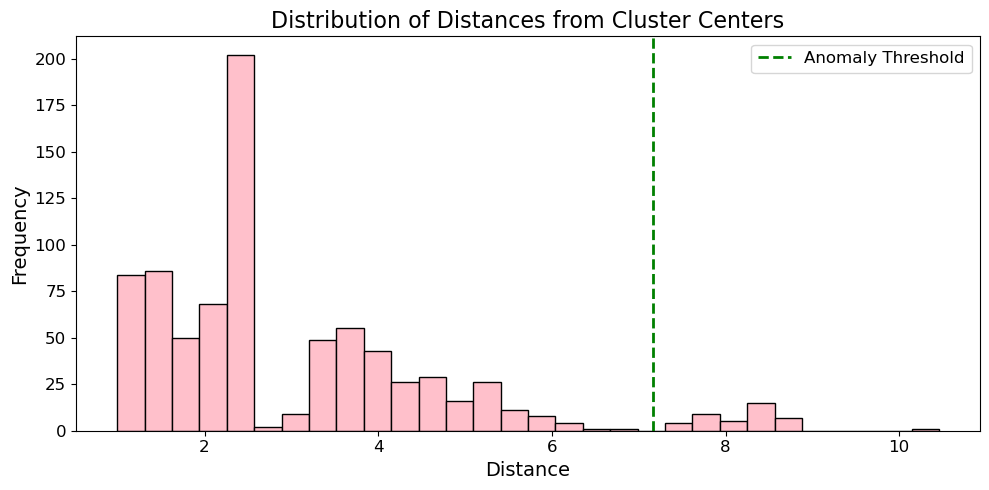

In [19]:

# Calculate the Euclidean distance from each point to its nearest cluster center
distances = np.min(cdist(X_scaled, kmeans.cluster_centers_, 'euclidean'), axis=1)

# Define the anomaly threshold as the top 5% of all distances
threshold = np.percentile(distances, 95)

# Add distance and anomaly flag to the dataframe
df['distance'] = distances
df['Anomaly'] = distances > threshold  # Mark points beyond threshold as anomalies

# Print the total number of anomalies detected
print("Anomalies detected:", df['Anomaly'].sum())

# Visualize the distribution of distances with the anomaly threshold marked
plt.figure(figsize=(10, 5))
plt.hist(distances, bins=30, color='pink', edgecolor='black')
plt.axvline(threshold, color='green', linestyle='--', linewidth=2, label='Anomaly Threshold')
plt.title("Distribution of Distances from Cluster Centers", fontsize=16)
plt.xlabel("Distance", fontsize=14)
plt.ylabel("Frequency", fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()


### STEP 5: Visualization of Clusters and Anomalies

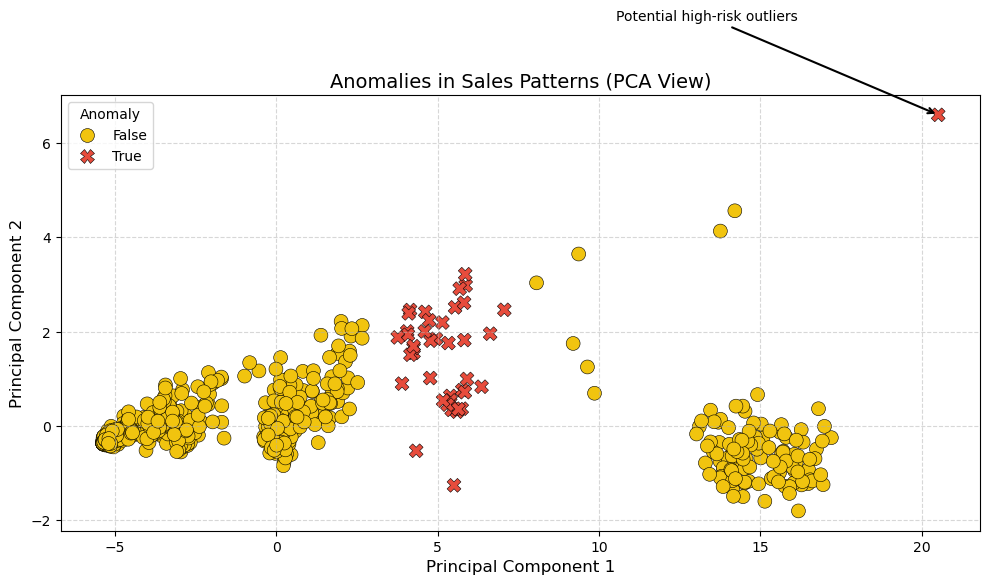

In [20]:

# Create a scatter plot of PCA-reduced data to visualize anomalies and clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=df, x='PC1', y='PC2',             # Use first two principal components for 2D plot
    hue='Anomaly',                         # Color points based on anomaly status
    palette={True: '#e74c3c', False: '#f1c40f'},  # Red for anomalies, yellow for normal points
    style='Anomaly', s=100, edgecolor='black', linewidth=0.4  # Style and marker settings
)

# Set plot title and axis labels with larger font sizes
plt.title('Anomalies in Sales Patterns (PCA View)', fontsize=14)
plt.xlabel('Principal Component 1', fontsize=12)
plt.ylabel('Principal Component 2', fontsize=12)

# Identify and annotate the furthest anomaly (for visual emphasis)
arrow_x = df[df['Anomaly']]['PC1'].max()
arrow_y = df[df['Anomaly']]['PC2'].max()
plt.annotate(
    'Potential high-risk outliers',             # Annotation label
    xy=(arrow_x, arrow_y),                      # Arrow points to max anomaly in PC1/PC2 space
    xytext=(arrow_x - 10, arrow_y + 2),         # Text positioned slightly away from point
    arrowprops=dict(facecolor='black', arrowstyle='->', lw=1.5),
    fontsize=10,
    color='black'
)

# Final plot formatting
plt.legend(title='Anomaly', loc='upper left')   # Move legend to top-left for clarity
plt.grid(True, linestyle='--', alpha=0.5)       # Light dashed grid for visual balance
plt.tight_layout()
plt.savefig("sales_anomaly_bubbles_arrow_red_yellow_left.png")  # Save figure
plt.show()                                      # Display the plot


### STEP 6: Top Anomalies Summary

In [21]:

# Filter only the rows flagged as anomalies and sort them by distance (most extreme first)
top_anomalies = df[df['Anomaly']].sort_values('distance', ascending=False)

# Display the top 5 anomalies with the highest deviation from their cluster center
print("Top 5 anomalies:")
display(top_anomalies[['Product_Code', 'distance']].head(5))


Top 5 anomalies:


,Product_Code,distance
406,P409,10.457830
532,P535,8.771528
262,P263,8.751167
199,P200,8.714186
534,P537,8.697972


### STEP 7: Final Summary

In [22]:

# Print the total number of detected anomalies as a concise wrap-up message
print("Analysis complete. Found", df['Anomaly'].sum(), "potential anomalies.")


Analysis complete. Found 41 potential anomalies.
